In [56]:
parPercents=[83.8202, 84.1504, 84.4806, 84.8108, 85.1410, 85.4712, 85.8014, 86.1316, 86.4816, 86.7920, 87.1222, 87.4524, 87.7826, 88.1128, 88.4430]
superfluousPercents=list(range(2, 31, 2))
egPercents=[100-par for par in parPercents]
egPercents

[16.1798,
 15.849599999999995,
 15.519400000000005,
 15.1892,
 14.858999999999995,
 14.528800000000004,
 14.198599999999999,
 13.868399999999994,
 13.5184,
 13.207999999999998,
 12.877799999999993,
 12.547600000000003,
 12.217399999999998,
 11.887200000000007,
 11.557000000000002]

In [57]:
(5.5/807.51)/((5.5/807.51)+(31)/914)

0.16723325929205807

In [58]:
nonsuperfluousPar=[par-sup for par, sup in zip(parPercents, superfluousPercents)]
nonsuperfluousEGPer=[egPer/(egPer+nonSupPar) for egPer, nonSupPar in zip(egPercents, nonsuperfluousPar)]

In [59]:
nonsuperfluousEGPer

[0.1651,
 0.16509999999999994,
 0.16510000000000005,
 0.1651,
 0.16509999999999994,
 0.16510000000000005,
 0.1651,
 0.16509999999999994,
 0.16485853658536584,
 0.16509999999999997,
 0.1650999999999999,
 0.16510000000000002,
 0.16509999999999997,
 0.1651000000000001,
 0.16510000000000002]

(15, 15)

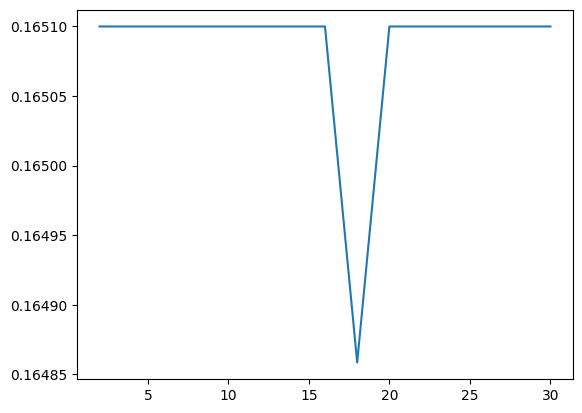

In [60]:
import matplotlib.pyplot as plt
plt.plot(superfluousPercents, nonsuperfluousEGPer)
len(superfluousPercents), len(nonsuperfluousEGPer)

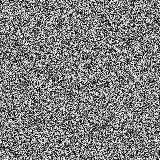

In [61]:
absorptionRate=.1651
import random
import torch
import torchvision as tv
from collections import deque

grid=torch.rand((160, 160))

tensorToImageTransform=tv.transforms.ToPILImage()

def corePhase(grid, prob=0.05):
    return (grid>prob).float()

tensorToImageTransform(grid)

def generateSample(grid, coreProb, growthProb, superfluousPar):
    rows, cols = 160, 160
    totVol=rows*cols
    egVol=0
    bfs=deque()
    for row in range(rows):
        for col in range(cols):
            if random.random()<coreProb:
                grid[row][col]=0
                egVol+=1
                bfs.append([row, col])

    iters=0
    dirs = [[0,1],[0,-1],[1,1],[1,-1],[1,0],[-1,1],[-1,-1],[-1,0]]

    while (totVol-egVol)/totVol>superfluousPar:
        [currX, currY]=bfs.popleft()
        adjWhite=False
        for dir in dirs:
            nx, ny=currX+dir[0], currY+dir[1]
            if nx<0 or nx>=rows or ny<0 or ny>=cols:
                continue
            if random.random()<growthProb and grid[nx][ny]==1:
                egVol+=1
                bfs.append([nx, ny])
                grid[nx][ny]=0
            if grid[nx][ny]==1:
                adjWhite=True
        if adjWhite:
            bfs.append([currX, currY])
    
    return grid

def generateSample2(grid, coreProb, growthProb, superfluousPar):
    rows, cols = 160, 160
    totVol=rows*cols
    egVol=0
    bfs=deque()
    for row in range(rows):
        for col in range(cols):
            if random.random()<coreProb:
                grid[row][col]=0
                egVol+=1
                bfs.append([row, col])

    iters=0
    dirs = [[0,1],[0,-1],[1,1],[1,-1],[1,0],[-1,1],[-1,-1],[-1,0]]

    while (totVol-egVol)/totVol>superfluousPar:
        sz=len(bfs)
        for i in range(sz):
            [currX, currY]=bfs.popleft()
            adjWhite=False
            for dir in dirs:
                nx, ny=currX+dir[0], currY+dir[1]
                if nx<0 or nx>=rows or ny<0 or ny>=cols:
                    continue
                if grid[nx][ny]!=0 and grid[nx][ny]!=1 and grid[nx][ny]-iters<0:
                    grid[nx][ny]=1
                if grid[nx][ny]==1:
                    grid[nx][ny]=random.random()+iters
                    adjWhite=adjWhite or grid[nx][ny]-iters>=growthProb
                if grid[nx][ny]-iters<growthProb and grid[nx][ny]!=0 and grid[nx][ny]!=1:
                    grid[nx][ny]=0
                    egVol+=1
                    bfs.append([nx, ny])
            if adjWhite:
                bfs.append([currX, currY])
        print(egVol)
        iters+=1
        
    return grid

def generateSample3(rows, cols, coreProb, growthProb, wtPercent):
    growthMaterial=(int)(wtPercent>=4)
    vol=0
    totVol=rows*cols
    pDensity=914
    egDensity=269
    egPerSaturatedEG=0.1651
    nonGrowthEndingVol=(wtPercent/egDensity)/(egPerSaturatedEG*(wtPercent/egDensity+(100-wtPercent)/pDensity)) if wtPercent<4 else 1-(wtPercent/egDensity)/(egPerSaturatedEG*(wtPercent/egDensity+(100-wtPercent)/pDensity))
    grid=[[(int)(not growthMaterial)]*cols for i in range(rows)]
    cores=[]
    for row in range(rows):
        for col in range(cols):
            if random.random()<coreProb:
                grid[row][col]=growthMaterial
                vol+=1
                cores.append([row, col])

    dirs = [[0,1],[0,-1],[1,1],[1,-1],[1,0],[-1,1],[-1,-1],[-1,0]]
    iters=0
    prevVol=0

    print(nonGrowthEndingVol, vol, totVol)
    
    while vol/totVol<nonGrowthEndingVol:
        idx=random.randint(0, len(cores)-1)
        [currX, currY]=cores[idx]
        adjNonGrowth=False
        for dir in dirs:
            nx, ny=currX+dir[0], currY+dir[1]
            if nx<0 or nx>=rows or ny<0 or ny>=cols:
                continue
            if grid[nx][ny]!=growthMaterial and random.random()<growthProb:
                grid[nx][ny]=growthMaterial
                cores.append([nx, ny])
                vol+=1
            if grid[nx][ny]!=growthMaterial:
                adjNonGrowth=True
        if not adjNonGrowth:
            cores[idx], cores[-1]=cores[-1], cores[idx]
            cores.pop()
        iters+=1
        if iters%(10000/growthProb)==0:
            print(iters, vol/totVol, vol, totVol, nonGrowthEndingVol, len(cores))
            if prevVol==vol:
                break
            prevVol=vol
    
    return grid



# grid=generateSample(grid, 0.002, 0.25, 0.2)
display(tensorToImageTransform(grid))

In [68]:
import cProfile
# grid=torch.rand((160, 160))
# grid=[[1]*160 for i in range(160)]
grid=generateSample3(160, 160, 0.002, 0.05, 0)

0.0 46 25600


46


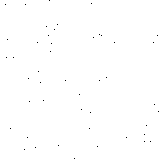

In [69]:
grid_tensor=torch.tensor(grid, dtype=torch.float32)
print(len(torch.nonzero(grid_tensor==0)))
display(tensorToImageTransform(grid_tensor))

In [70]:
#eg true density
egDensity=268.934
parDensity=914
egPerSaturatedEG=0.1651

totVol=160*160
saturatedEgVol=len(torch.nonzero(grid_tensor==0))
superfluousParVol=totVol-saturatedEgVol
parVol=superfluousParVol+(1-egPerSaturatedEG)*saturatedEgVol
egVol=egPerSaturatedEG*saturatedEgVol
egWeight=egVol*egDensity
parWeight=parVol*parDensity
egWeight/(egWeight+parWeight)

8.730827241261654e-05

In [71]:
saturatedEgDensity=807.51
egDensities=[(saturatedEgDensity-(1-egPerSaturatedEG)*parDensity)/egPerSaturatedEG]
egDensities

[268.99697153240436]

In [72]:
# def lbm_list(grid):
#     # setting constants, temperature field, and distribution function
#     parRelaxTime=0.558915
#     satEGRelaxTime=0.978183*10
#     parThermalConductivity=0.305
#     satEGThermalConductivity=2.1

#     tHot=293
#     tCold=283
#     tInitial=(tHot+tCold)/2

#     rows=len(grid)
#     cols=len(grid[0])

#     deltaX=1
#     deltaT=1

#     omega=1/4
#     directions=[[0,1],[1,0],[-1,0],[0,-1]]

#     T=[[tInitial]*cols for row in range(rows)]
#     distributionFunction=[[[0]*cols for row in range(rows)] for dir in range(4)]

#     def applyBoundaryConditions(T, distributionFunction):
#         for row in range(rows):
#             T[row][0]=tHot
#             T[row][-1]=tCold

#             for dir in range(4):
#                 distributionFunction[dir][row][0]=omega*T[row][0]
#                 distributionFunction[dir][row][-1]=omega*T[row][-1]

#     def equilibriumDistribution(T):
#         return [[t*omega for t in row] for row in T]
    
#     def computeTemperature(distributionFunction):
#         return [[distributionFunction[0][row][col]+distributionFunction[1][row][col]+distributionFunction[2][row][col]+distributionFunction[3][row][col] for col in len(cols)] for row in len(rows)]
    
#     def collisionStep(distributionFunction, relaxTime):
#         eqDistribtuionFunction=equilibriumDistribution(computeTemperature(distributionFunction))
#         distributionFunction=[]

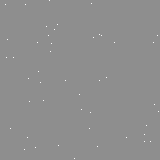

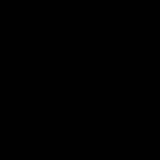

TC 0.16658406330621486
RIGHT FLUX 1812000.0
LEFT FLUX 1811600.0
EG RIGHT FLUX 3254.5
EG LEFT FLUX 3254.5
PAR RIGHT FLUX 1808745.5
PAR LEFT FLUX 1808345.5


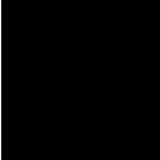

TC 0.5321348619789424
RIGHT FLUX 1822444.684661746
LEFT FLUX 1821166.9277108887
EG RIGHT FLUX 3276.8695623893227
EG LEFT FLUX 3273.9306741119053
PAR RIGHT FLUX 1819167.8150993565
PAR LEFT FLUX 1817892.9970367767


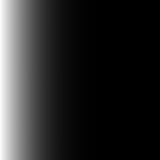

TC 0.5354156060715639
RIGHT FLUX 1826881.2211638165
LEFT FLUX 1825595.5865227948
EG RIGHT FLUX 3286.3681598207986
EG LEFT FLUX 3283.432794733366
PAR RIGHT FLUX 1823594.8530039957
PAR LEFT FLUX 1822312.1537280614


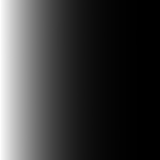

TC 0.5366695889054003
RIGHT FLUX 1830216.8453179428
LEFT FLUX 1828928.1996257822
EG RIGHT FLUX 3292.9461103902904
EG LEFT FLUX 3290.0720234122323
PAR RIGHT FLUX 1826923.8992075524
PAR LEFT FLUX 1825638.1276023698


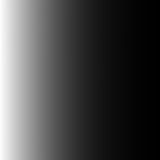

TC 0.5372017795932298
RIGHT FLUX 1832870.326615361
LEFT FLUX 1831580.403032201
EG RIGHT FLUX 3297.9139897617006
EG LEFT FLUX 3295.0974338003457
PAR RIGHT FLUX 1829572.4126255994
PAR LEFT FLUX 1828285.3055984005


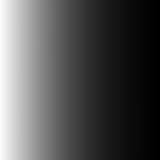

TC 0.5374320131847277
RIGHT FLUX 1835003.181954773
LEFT FLUX 1833712.7055369974
EG RIGHT FLUX 3301.7925475999123
EG LEFT FLUX 3299.0235568350586
PAR RIGHT FLUX 1831701.3894071733
PAR LEFT FLUX 1830413.6819801624


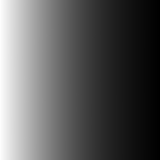

TC 0.5375338836352076
RIGHT FLUX 1836720.8032359036
LEFT FLUX 1835430.0822078132
EG RIGHT FLUX 3304.8674210080703
EG LEFT FLUX 3302.1369427833774
PAR RIGHT FLUX 1833415.9358148957
PAR LEFT FLUX 1832127.9452650298


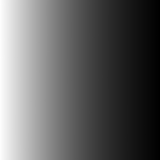

TC 0.5375807160683702
RIGHT FLUX 1838104.5183266387
LEFT FLUX 1836813.6848449744
EG RIGHT FLUX 3307.324032842661
EG LEFT FLUX 3304.6246173863046
PAR RIGHT FLUX 1834797.1942937956
PAR LEFT FLUX 1833509.0602275878


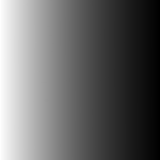

TC 0.537603597174468
RIGHT FLUX 1839219.318381614
LEFT FLUX 1837928.4299580648
EG RIGHT FLUX 3309.294576309057
EG LEFT FLUX 3306.6201951771645
PAR RIGHT FLUX 1835910.023805305
PAR LEFT FLUX 1834621.8097628877


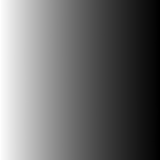

TC 0.5376157744306386
RIGHT FLUX 1840117.4806232918
LEFT FLUX 1838826.5629598359
EG RIGHT FLUX 3310.878543848569
EG LEFT FLUX 3308.2243346358173
PAR RIGHT FLUX 1836806.6020794432
PAR LEFT FLUX 1835518.3386251996


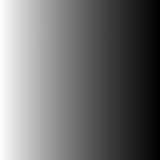

TC 0.5376229487476434
RIGHT FLUX 1840841.1079895273
LEFT FLUX 1839550.1730991725
EG RIGHT FLUX 3312.153172948731
EG LEFT FLUX 3309.515216653438
PAR RIGHT FLUX 1837528.954816579
PAR LEFT FLUX 1836240.6578825193


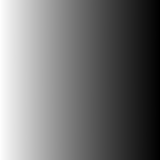

TC 0.5376276179974815
RIGHT FLUX 1841424.1181718113
LEFT FLUX 1840133.1720697002
EG RIGHT FLUX 3313.179466036787
EG LEFT FLUX 3310.554604703528
PAR RIGHT FLUX 1838110.9387057747
PAR LEFT FLUX 1836822.6174649969


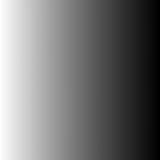

TC 0.5376309118193349
RIGHT FLUX 1841893.8367679417
LEFT FLUX 1840602.8827567382
EG RIGHT FLUX 3314.0060555132163
EG LEFT FLUX 3311.3917446512482
PAR RIGHT FLUX 1838579.8307124285
PAR LEFT FLUX 1837291.4910120866


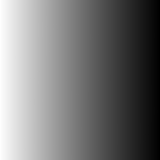

TC 0.537633368352282
RIGHT FLUX 1842272.2790033561
LEFT FLUX 1840981.31909355
EG RIGHT FLUX 3314.6719061749586
EG LEFT FLUX 3312.06609566308
PAR RIGHT FLUX 1838957.6070971808
PAR LEFT FLUX 1837669.252997887


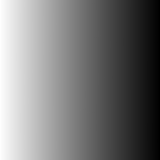

TC 0.5376352644263341
RIGHT FLUX 1842577.1819089882
LEFT FLUX 1841286.217446348
EG RIGHT FLUX 3315.208319593806
EG LEFT FLUX 3312.6093576597314
PAR RIGHT FLUX 1839261.9735893947
PAR LEFT FLUX 1837973.6080886882


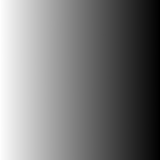

TC 0.5376367570387609
RIGHT FLUX 1842822.835766902
LEFT FLUX 1841531.8677202156
EG RIGHT FLUX 3315.6404762188754
EG LEFT FLUX 3313.0470320506056
PAR RIGHT FLUX 1839507.1952906833
PAR LEFT FLUX 1838218.8206881648


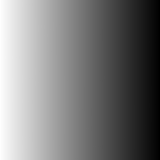

TC 0.5376379448521974
RIGHT FLUX 1843020.753928025
LEFT FLUX 1841729.7830291728
EG RIGHT FLUX 3315.9886471591753
EG LEFT FLUX 3313.399648543597
PAR RIGHT FLUX 1839704.7652808658
PAR LEFT FLUX 1838416.3833806296


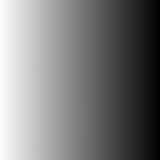

TC 0.5376388956318696
RIGHT FLUX 1843180.212445633
LEFT FLUX 1841889.239263778
EG RIGHT FLUX 3316.2691575755257
EG LEFT FLUX 3313.683740650548
PAR RIGHT FLUX 1839863.9432880578
PAR LEFT FLUX 1838575.5555231278


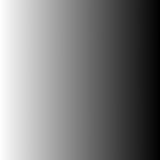

TC 0.5376396590363026
RIGHT FLUX 1843308.6848365015
LEFT FLUX 1842017.7098215674
EG RIGHT FLUX 3316.495157423329
EG LEFT FLUX 3313.9126261923193
PAR RIGHT FLUX 1839992.1896790778
PAR LEFT FLUX 1838703.797195375


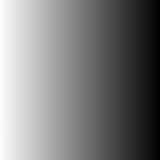

TC 0.5376402729912941
RIGHT FLUX 1843412.1923545606
LEFT FLUX 1842121.2158654039
EG RIGHT FLUX 3316.6772401309872
EG LEFT FLUX 3314.0970338435827
PAR RIGHT FLUX 1840095.5151144294
PAR LEFT FLUX 1838807.11883156


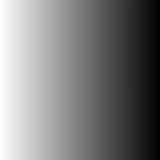

TC 0.537640767177153
RIGHT FLUX 1843495.5861972535
LEFT FLUX 1842204.6085214627
EG RIGHT FLUX 3316.8239400900293
EG LEFT FLUX 3314.2456069612085
PAR RIGHT FLUX 1840178.7622571634
PAR LEFT FLUX 1838890.3629145015


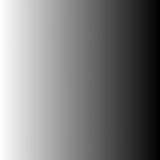

TC 0.5376411651367112
RIGHT FLUX 1843562.7748725289
LEFT FLUX 1842271.7962411614
EG RIGHT FLUX 3316.942133065442
EG LEFT FLUX 3314.3653091013834
PAR RIGHT FLUX 1840245.8327394628
PAR LEFT FLUX 1838957.4309320601


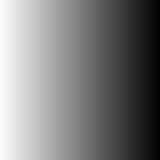

TC 0.5376414856815058
RIGHT FLUX 1843616.9073833502
LEFT FLUX 1842325.9279822938
EG RIGHT FLUX 3317.0373586263768
EG LEFT FLUX 3314.4617505648366
PAR RIGHT FLUX 1840299.870024724
PAR LEFT FLUX 1839011.466231729


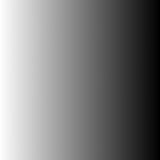

TC 0.5376417439031209
RIGHT FLUX 1843660.5208154982
LEFT FLUX 1842369.5407944026
EG RIGHT FLUX 3317.114079849564
EG LEFT FLUX 3314.5394514152727
PAR RIGHT FLUX 1840343.4067356486
PAR LEFT FLUX 1839055.0013429874


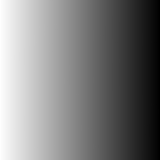

TC 0.5376419519321294
RIGHT FLUX 1843695.65924591
LEFT FLUX 1842404.678725297
EG RIGHT FLUX 3317.1758925264667
EG LEFT FLUX 3314.602053357371
PAR RIGHT FLUX 1840378.4833533834
PAR LEFT FLUX 1839090.07667194


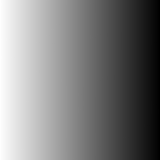

TC 0.5376421195305482
RIGHT FLUX 1843723.969544624
LEFT FLUX 1842432.9886215755
EG RIGHT FLUX 3317.225693704282
EG LEFT FLUX 3314.6524904296552
PAR RIGHT FLUX 1840406.74385092
PAR LEFT FLUX 1839118.336131146


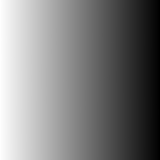

TC 0.5376422545588196
RIGHT FLUX 1843746.778560394
LEFT FLUX 1842455.797313117
EG RIGHT FLUX 3317.265817470503
EG LEFT FLUX 3314.693126522754
PAR RIGHT FLUX 1840429.5127429229
PAR LEFT FLUX 1839141.1041865945


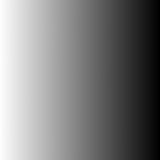

TC 0.5376423633467985
RIGHT FLUX 1843765.1553075155
LEFT FLUX 1842474.173799018
EG RIGHT FLUX 3317.2981443494136
EG LEFT FLUX 3314.7258661727196
PAR RIGHT FLUX 1840447.857163166
PAR LEFT FLUX 1839159.4479328452


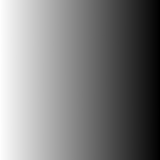

TC 0.5376424509945362
RIGHT FLUX 1843779.961068456
LEFT FLUX 1842488.9793494996
EG RIGHT FLUX 3317.324189439603
EG LEFT FLUX 3314.7522438239175
PAR RIGHT FLUX 1840462.6368790166
PAR LEFT FLUX 1839174.2271056753


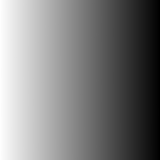

TC 0.5376425216104268
RIGHT FLUX 1843791.8897604924
LEFT FLUX 1842500.9078719737
EG RIGHT FLUX 3317.3451734241135
EG LEFT FLUX 3314.773495745881
PAR RIGHT FLUX 1840474.544587068
PAR LEFT FLUX 1839186.1343762276


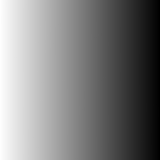

TC 0.5376425785042628
RIGHT FLUX 1843801.5004582654
LEFT FLUX 1842510.5184331338
EG RIGHT FLUX 3317.3620797816593
EG LEFT FLUX 3314.7906179750303
PAR RIGHT FLUX 1840484.1383784835
PAR LEFT FLUX 1839195.7278151587


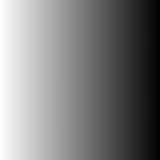

TC 0.5376426243420883
RIGHT FLUX 1843809.2435965235
LEFT FLUX 1842518.2614613266
EG RIGHT FLUX 3317.3757008804428
EG LEFT FLUX 3314.8044129970503
PAR RIGHT FLUX 1840491.8678956432
PAR LEFT FLUX 1839203.4570483295


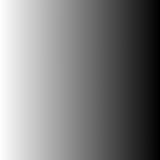

TC 0.5376426612729316
RIGHT FLUX 1843815.4820811278
LEFT FLUX 1842524.499857253
EG RIGHT FLUX 3317.386675114939
EG LEFT FLUX 3314.8155273578627
PAR RIGHT FLUX 1840498.0954060126
PAR LEFT FLUX 1839209.684329895


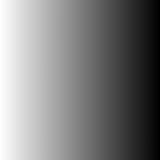

TC 0.5376426910270304
RIGHT FLUX 1843820.5082977412
LEFT FLUX 1842529.526002421
EG RIGHT FLUX 3317.395516826223
EG LEFT FLUX 3314.82448196599
PAR RIGHT FLUX 1840503.1127809146
PAR LEFT FLUX 1839214.7015204548


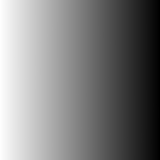

TC 0.5376427149994161
RIGHT FLUX 1843824.5578153802
LEFT FLUX 1842533.5754624978
EG RIGHT FLUX 3317.402640408144
EG LEFT FLUX 3314.831696506537
PAR RIGHT FLUX 1840507.1551749723
PAR LEFT FLUX 1839218.7437659912


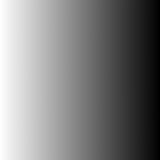

TC 0.537642734313521
RIGHT FLUX 1843827.8204270762
LEFT FLUX 1842536.838027817
EG RIGHT FLUX 3317.40837972916
EG LEFT FLUX 3314.837509111017
PAR RIGHT FLUX 1840510.412047347
PAR LEFT FLUX 1839222.0005187062


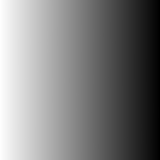

TC 0.537642749874317
RIGHT FLUX 1843830.449045106
LEFT FLUX 1842539.4666084824
EG RIGHT FLUX 3317.4130037801065
EG LEFT FLUX 3314.842192204917
PAR RIGHT FLUX 1840513.0360413261
PAR LEFT FLUX 1839224.6244162775


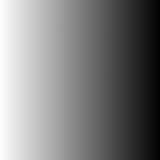

TC 0.5376427624115602
RIGHT FLUX 1843832.5668676947
LEFT FLUX 1842541.5844009668
EG RIGHT FLUX 3317.416729281276
EG LEFT FLUX 3314.84596527576
PAR RIGHT FLUX 1840515.1501384138
PAR LEFT FLUX 1839226.7384356915


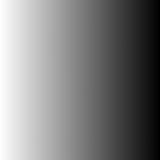

CONVERGED ON STEP 37611 WITH ERROR 9.999301616032756e-10


In [ ]:
import numpy as np

def lbm_np(grid):
    # setting constants, temperature field, and distribution function
    parRelaxTime=0.558915
    satEGRelaxTime=0.978183

    tHot=293
    tCold=283
    tInitial=tCold

    rows=len(grid)
    cols=len(grid[0])
    if type(grid) is list:
        grid=np.array(grid)
    omega=1/4

    directions=np.array([[1,0],[0,1],[-1,0],[0,-1]])
    T=np.full((rows, cols), tInitial)
    distributionFunction=np.zeros((4, rows, cols))

    # helper functions
    def applyBoundaryConditions(T, distributionFunction):
        T[:,0]=tHot
        T[:,-1]=tCold
        
        # eq=equilibriumDistribution(T)
        distributionFunction[:,:,0]=omega*T[:,0]
        # distributionFunction[3,:,0]+=distributionFunction[3,:,1]-eq[:,1]
        distributionFunction[:,:,-1]=omega*T[:,-1]
        # distributionFunction[1,:,-1]+=distributionFunction[1,:,-2]-eq[:,-2]

    def equilibriumDistribution(T):
        return T*omega
    
    def calculateTemperature(distributionFunction):
        return np.sum(distributionFunction, axis=0)
    
    def collisionStep(distributionFunction, relaxMap):
        eq=equilibriumDistribution(calculateTemperature(distributionFunction))
        for dir in range(4):
            distributionFunction[dir]-=(distributionFunction[dir]-eq)/relaxMap

    def streamingStep(distributionFunction):
        for dir, [x, y] in enumerate(directions):
            distributionFunction[dir]=np.roll(np.roll(distributionFunction[dir], x, axis=0), y, axis=1)

    def calculateThermalConductivity(distributionFunction):
        deltaT=tHot-tCold
        qFlux=(np.sum(distributionFunction[1,:,:])-np.sum(distributionFunction[3,:,:]))*(np.mean(relaxMap)-0.5)/np.mean(relaxMap)
        return 1000*qFlux/(deltaT*rows*cols)

    # setting up initial conditions
    numSteps=100000
    tolerance=1e-9
    relaxMap=np.where(grid==1, parRelaxTime, satEGRelaxTime)
    display(tensorToImageTransform(relaxMap))
    display(tensorToImageTransform((T-tCold)/(tHot-tCold)))
    for dir in range(4):
        distributionFunction[dir,:,:]=equilibriumDistribution(T)
    applyBoundaryConditions(T, distributionFunction)
    
    for step in range(numSteps):
        T_old=T.copy()
        for dir in range(4):
            collisionStep(distributionFunction, relaxMap)
        streamingStep(distributionFunction)
        applyBoundaryConditions(T, distributionFunction)
        T=calculateTemperature(distributionFunction)

        error=np.sqrt(np.sum(np.square((T-T_old)))/np.sum(np.square(T)))
        if error<tolerance:
            print("CONVERGED ON STEP", step, "WITH ERROR", error)
            break
        if step%1000==0:
            print('TC', calculateThermalConductivity(distributionFunction))
            print('RIGHT FLUX', np.sum(distributionFunction[1,:,:]))
            print('LEFT FLUX', np.sum(distributionFunction[3,:,:]))
            print('EG RIGHT FLUX', np.sum(np.where(grid==0, distributionFunction[1,:,:], 0)))
            print('EG LEFT FLUX', np.sum(np.where(grid==0, distributionFunction[3,:,:], 0)))
            print('PAR RIGHT FLUX', np.sum(np.where(grid==1, distributionFunction[1,:,:], 0)))
            print('PAR LEFT FLUX', np.sum(np.where(grid==1, distributionFunction[3,:,:], 0)))
            display(tensorToImageTransform((T-tCold)/(tHot-tCold)))
    return T, calculateThermalConductivity(distributionFunction)
    

temps, cond=lbm_np(grid)

1.5117444999084537

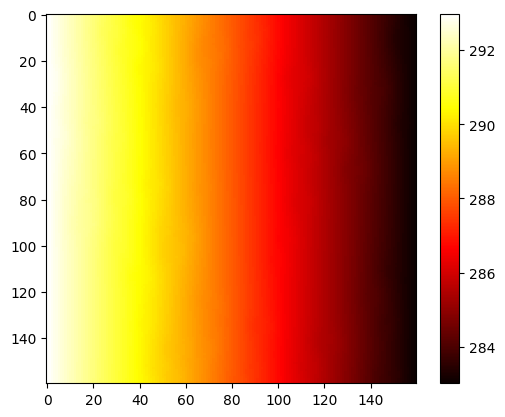

In [ ]:
plt.imshow(temps, cmap='hot', interpolation='nearest')
plt.colorbar()
cond

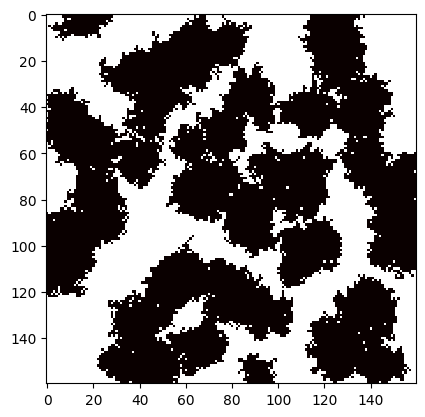

In [ ]:
plt.imshow(grid, cmap='hot', interpolation='nearest')

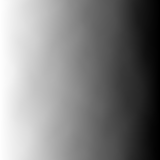

In [ ]:
display(tensorToImageTransform((temps-np.min(temps))/(np.max(temps)-np.min(temps))))

In [ ]:
temps[0,:]

array([293.00047694, 292.93715478, 292.88090918, 292.82654121,
       292.77212588, 292.71650798, 292.65843683, 292.59669875,
       292.53080225, 292.45724897, 292.37761586, 292.29776422,
       292.21820781, 292.13848391, 292.05774717, 291.97432301,
       291.88354515, 291.80672098, 291.74649007, 291.68488173,
       291.6227046 , 291.56202382, 291.50328949, 291.44565083,
       291.39156843, 291.3431831 , 291.29927743, 291.25749252,
       291.21654582, 291.17602312, 291.13559834, 291.09498838,
       291.05386159, 291.01183004, 290.96834126, 290.92122642,
       290.86768311, 290.81059852, 290.75263337, 290.6934952 ,
       290.63302378, 290.57103682, 290.50740127, 290.44241161,
       290.37595033, 290.30800777, 290.23846758, 290.16603612,
       290.09312586, 290.01966359, 289.9469338 , 289.87462391,
       289.80211809, 289.73058857, 289.66018986, 289.59174977,
       289.52535297, 289.46068696, 289.39746264, 289.33536703,
       289.27412816, 289.21694144, 289.15992408, 289.10

In [ ]:
npGrid=np.array(grid)
np.sum(npGrid==1)/(160*160)

0.250546875

In [ ]:
test=np.array([[0,1,0,1,0,1],[2,0,2,0,2,0]])
np.roll(test, 1, axis=1)

array([[1, 0, 1, 0, 1, 0],
       [0, 2, 0, 2, 0, 2]])